In [1]:
#!pip install transformers

In [2]:
import pandas as pd
import numpy as np
import transformers
from transformers import BertPreTrainedModel, BertTokenizer, BertModel, BertConfig
import torch
from torch.utils.data import DataLoader,TensorDataset, RandomSampler, SequentialSampler
import math
from tqdm import trange
from tqdm import tqdm_notebook as tqdm

tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
device = torch.device(0)
torch.cuda.memory_allocated(device)

I1008 21:07:19.976666 140055077836544 file_utils.py:39] PyTorch version 1.1.0 available.
I1008 21:07:20.215218 140055077836544 modeling_xlnet.py:194] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
I1008 21:07:20.395566 140055077836544 tokenization_utils.py:373] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/enlr/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


0

In [3]:
cls_id = tokenizer.convert_tokens_to_ids(tokenizer._cls_token)
sep_id = tokenizer.convert_tokens_to_ids(tokenizer._sep_token)


max_length = 512

def get_features_from_example(ex):
    input = ex.input.copy()
    pab = ex.pab_pos.copy()

    #add special tokens [CLS at beginning], [SEP at end], [optional SEP before pos]
    input = [cls_id]+input.tolist()+[sep_id]
    pab += 1
    
    #attention masking and padding
    mask = [1] * len(input)
    pad_length = max_length -len(input)
    #padding tokens and mask with 0
    input = input + [0]*pad_length
    mask = mask + [0]*pad_length

    assert len(input) == max_length
    assert len(mask) == max_length
    
    return input, mask, pab, int(ex.label)

In [4]:
def create_dataset(df):
    features = [get_features_from_example(df.iloc[i]) for i in range(len(df))]

    ids = torch.tensor([feature[0] for feature in features])
    masks = torch.tensor([feature[1] for feature in features])
    pabs = torch.tensor([feature[2] for feature in features])
    labels = torch.tensor([feature[3] for feature in features])

    print(ids.size(), masks.size(), pabs.size(), labels.size())

    return TensorDataset(ids, masks, pabs, labels)


## Cancat Model architecture

In [5]:
'''
logits = concat(P_hidden, A_hidden, B_hidden)
'''

class BertForPronounResolution_Concat(BertPreTrainedModel):
    def __init__(self, config : BertConfig):
        super(BertForPronounResolution_Concat, self).__init__(config)
        
        self.bert = BertModel(config)
        
        #[P][A][B] classification layer
        self.classification = torch.nn.Linear(config.hidden_size * 3 , 3)
        
        self.init_weights()
    
    def forward(self, input_ids, attention_mask, pab, labels = None, token_type_ids = None ):
   
        #print(f'input shape = {input_ids.size()}')
        output = self.bert(input_ids, attention_mask, token_type_ids, None, None)
        last_hidden_states = output[0]
        
        batches = last_hidden_states.size()[0]
        row_indexes = torch.arange(batches).unsqueeze(1) # row numbers in a column matrix
        pab_hidden_states = last_hidden_states[row_indexes, pab] #batch size x 3 x hidden size
        
        concatenated_states = pab_hidden_states.view(batches,-1)
        
        #print(concatenated_states)
        logits = self.classification(concatenated_states)
        
        output = (logits,) + output[2:] #hidden states and attention if present
        
        if labels is not None:
            loss_fun = torch.nn.CrossEntropyLoss()
            loss = loss_fun(logits, labels)
            
            output = (loss,) + output
            
        return output

## Mul Model Architecture

In [6]:
'''
A_att, B_att = Attention of P wrt A and B/sqrt(hiddensize)
Neither_att = Attention of P wrt random tranable tensor/sqrt(hiddensize)

logits = A_att, B_att, Neither_att
'''
class BertForPronounResolution_Mul(BertPreTrainedModel):
    def __init__(self, config : BertConfig):
        super(BertForPronounResolution_Mul, self).__init__(config)
        
        self.bert = BertModel(config)  
        self.init_weights()
        
        self.neither_params = torch.nn.Parameter(data = torch.randn(config.hidden_size,))
        #TODO: use a trainable tensor instead of CLS
        #self.trainable_tensor = torch.nn.
    
    def forward(self, input_ids, attention_mask, pab, labels = None, token_type_ids = None ):
   
        #pabc = torch.cat(( pab, torch.zeros_like(pab[:,0:1])), dim =1)[:,[0,3,1,2]]
        
        #print(f'input shape = {input_ids.size()}')
        output = self.bert(input_ids, attention_mask, token_type_ids, None, None)
        last_hidden_states = output[0]
        
        batches = last_hidden_states.size()[0]
        row_indexes = torch.arange(batches).unsqueeze(1) # row numbers in a column matrix
        
        pab_hidden_states = last_hidden_states[row_indexes, pab] #batch size x 3 x hidden size
        #print(pab_hidden_states)
        
        p_state = pab_hidden_states[:,0:1]
        attentions = pab_hidden_states[:,1:] * p_state#batch size x 2 x hidden size
        
        neither_att = p_state * self.neither_params
        
        attentions = torch.cat((neither_att, attentions), dim = 1)
        #print(attentions.size())
        #dividing sum with hidden size length to avoid high values. Done in Bert paper too
        logits = torch.sum(attentions, dim = 2)/math.sqrt(self.config.hidden_size) #batch size x 3 

        #print(logits)
        
        output = (logits,) + output[2:] #hidden states and attention if present
        
        if labels is not None:
            loss_fun = torch.nn.CrossEntropyLoss()
            loss = loss_fun(logits, labels)
            
            output = (loss,) + output
            
        return output

# m = BertForPronounResolution_Mul.from_pretrained('bert-base-uncased')
# a = torch.randint(high = 100,size = (2,5))
# pab = torch.randint(low = 1, high = 5, size = (2,3))
# m(a,None,pab)


## Segment ID model architecture

In [7]:
'''
input = same as bert
input embedding ids = 1 for P, 2 For A, 3 for B, 0 for rest. A,B and P are only first tokens of their respective words
logits = CLS_hidden
'''

class BertForPronounResolution_Segment(BertPreTrainedModel):
    def __init__(self, config):
        super(BertForPronounResolution_Segment, self).__init__(config)
        self.bert = BertModel(config)
        self.config.type_vocab_size = 4
        
        self.classification = torch.nn.Linear(config.hidden_size , 3)
        self.token_type_embeddings = torch.nn.Embedding(config.type_vocab_size, config.hidden_size)
        
        self.init_weights()
        

    def post_init(self):
        #print(self.bert.embeddings.token_type_embeddings.weight)
        self.bert.embeddings.token_type_embeddings = self.token_type_embeddings
        #print(self.bert.embeddings.token_type_embeddings.weight)

    def get_token_type_ids(self,inp,p):
        tokentypes = torch.zeros_like(inp)
        tokentypes[p[0]]=1
        tokentypes[p[1]]=2
        tokentypes[p[2]]=3    
        return tokentypes
        
    def forward(self, input_ids, attention_mask, pab, labels = None, token_type_ids = None ):
   
        #print([ self.get_token_type_ids(inp,p)  for inp,p in zip(input_ids, pab) ])
        token_type_ids = torch.cat([ self.get_token_type_ids(inp,p).unsqueeze(0)  for inp,p in zip(input_ids, pab) ], dim =0)
        
        #print(f'token types = {token_type_ids}')
        
        output = self.bert(input_ids, attention_mask, token_type_ids, None, None)
        
        pooler_output = output[1]

        logits = self.classification(pooler_output)
        #print(logits)
        
        output = (logits,) + output[2:] #hidden states and attention if present
        
        if labels is not None:
            loss_fun = torch.nn.CrossEntropyLoss()
            loss = loss_fun(logits, labels)
            
            output = (loss,) + output
            
        return output

# m = BertForPronounResolution_Segment.from_pretrained('bert-base-uncased')
# m.post_init()
        
# a = torch.randint(high = 100,size = (2,5))
# pab = torch.randint(low = 1, high = 5, size = (2,3))
# m(a,None,pab)


## Create datasets

In [8]:
train_df =  pd.read_pickle('train_processed.pkl')
val_df =  pd.read_pickle('val_processed.pkl')

train_dataset = create_dataset(train_df)
val_dataset = create_dataset(val_df)

#test_data = train_dataset[0:2]
#test_data = (t.to(device) for t in test_data)
#%time model(*test_data)

torch.Size([2000, 512]) torch.Size([2000, 512]) torch.Size([2000, 3]) torch.Size([2000])
torch.Size([454, 512]) torch.Size([454, 512]) torch.Size([454, 3]) torch.Size([454])


### args

In [10]:
import argparse
args = argparse.Namespace(
    epochs = 2,
    lr = 2E-5,
    per_step_batch_size = 64,
    gradient_acc = 16
    )

batch_size = args.per_step_batch_size//args.gradient_acc
args.batch_size = batch_size


## Train and evaluate

In [11]:
def evaluate(val_dataset,model):
    val_sampler = SequentialSampler(val_dataset)
    val_dataloader = DataLoader(val_dataset,batch_size= 64, sampler = val_sampler)

    all_labels = []
    all_preds = []
    total_loss = 0
    acc = 0
    model.eval()
    steps = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            labels = batch[-1]
            batch = tuple(t.to(device) for t in batch)
            loss,logits = model(*batch)
            preds = torch.argmax(logits, dim = 1)

            total_loss+=loss.item()
            all_labels.extend(labels.tolist())
            all_preds.extend(preds.tolist())
            steps += 1


    acc = np.sum(np.array(all_preds) == np.array(all_labels))/ len(all_preds)
    loss = total_loss/steps
    return loss,acc

In [12]:
import matplotlib.pyplot as plt

def train(train_dataset, val_dataset, model, args):
    
    optimizer = torch.optim.Adam(model.parameters(),lr = args.lr) #change it to AdamW later
    sampler = RandomSampler(train_dataset)
    dataloader = DataLoader(train_dataset,batch_size= args.batch_size, sampler = sampler)

    losses = []
    total_loss = 0
    

    
    for epoch in tqdm(range(args.epochs),position=1, total=args.epochs):
        
        model.train()
        batch_iterator = tqdm(dataloader, desc='batch_iterator')
        
        for step, batch in enumerate(batch_iterator):
            batch = (t.to(device) for t in batch)
            loss,logits = model(*batch)

            #print(f'step = {step}, loss = {losses[-1]}')

            loss = loss/args.gradient_acc
            loss.backward()

            total_loss+=loss.item()

            if (step+1) % args.gradient_acc == 0:
                optimizer.step()
                optimizer.zero_grad()
                losses.append(total_loss)
                batch_iterator.set_postfix({'loss':losses[-1]}, refresh=True)
                batch_iterator.write(f'step = {step}, loss = {total_loss}')
                total_loss=0
        val_loss , val_acc = evaluate(val_dataset, model)
        batch_iterator.write(f'Epoch = {epoch}, Val loss = {val_loss}, val_acc = {val_acc}')
        
    return losses

    

# 1. concat model

In [14]:
model = BertForPronounResolution_Concat.from_pretrained('bert-base-uncased')
#model = BertForPronounResolutionMul.from_pretrained('bert-base-uncased')
model = model.to(device)
torch.cuda.memory_allocated(device)

I1008 21:07:58.572713 140055077836544 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/enlr/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.bf3b9ea126d8c0001ee8a1e8b92229871d06d36d8808208cc2449280da87785c
I1008 21:07:58.573921 140055077836544 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30522
}

I1008 21:07:58.735274 140055077836544 modeli

439089664

step = 15, loss = 1.1485895328223705
step = 31, loss = 0.9655069299042225
step = 47, loss = 0.9469248987734318
step = 63, loss = 1.0834374725818634
step = 79, loss = 0.9512680061161518
step = 95, loss = 0.914986377581954
step = 111, loss = 0.9080746918916702
step = 127, loss = 0.7752458080649376
step = 143, loss = 0.8725780099630356
step = 159, loss = 0.7762089371681213
step = 175, loss = 0.8876235000789165
step = 191, loss = 0.8008579201996326
step = 207, loss = 0.6995056588202715
step = 223, loss = 0.7249683924019337
step = 239, loss = 0.7509226743131876
step = 255, loss = 0.8455681372433901
step = 271, loss = 0.8005466796457767
step = 287, loss = 0.8135981354862452
step = 303, loss = 0.7824943475425243
step = 319, loss = 0.6589502636343241
step = 335, loss = 0.6913174111396074
step = 351, loss = 0.7488800175487995
step = 367, loss = 0.7973267715424299
step = 383, loss = 0.7245789766311646
step = 399, loss = 0.7510859575122595
step = 415, loss = 0.7517631314694881
step = 431, loss = 

Epoch = 0, Val loss = 0.7746969312429428, val_acc = 0.6740088105726872


step = 15, loss = 0.7802764642983675
step = 31, loss = 0.5636083036661148
step = 47, loss = 0.5140633638948202
step = 63, loss = 0.6108039803802967
step = 79, loss = 0.5273195058107376
step = 95, loss = 0.6455754078924656
step = 111, loss = 0.535988662391901
step = 127, loss = 0.5601743068546057
step = 143, loss = 0.7393139312043786
step = 159, loss = 0.4899218659847975
step = 175, loss = 0.5093967393040657
step = 191, loss = 0.47866042517125607
step = 207, loss = 0.4324350506067276
step = 223, loss = 0.4023373406380415
step = 239, loss = 0.5818480271846056
step = 255, loss = 0.419376777485013
step = 271, loss = 0.4139788821339607
step = 287, loss = 0.498704781755805
step = 303, loss = 0.44979036785662174
step = 319, loss = 0.3919243449345231
step = 335, loss = 0.4841308146715164
step = 351, loss = 0.491360186599195
step = 367, loss = 0.4630994535982609
step = 383, loss = 0.4671268127858639
step = 399, loss = 0.4911157824099064
step = 415, loss = 0.4507456822320819
step = 431, loss = 0

Epoch = 1, Val loss = 0.6115955822169781, val_acc = 0.751101321585903


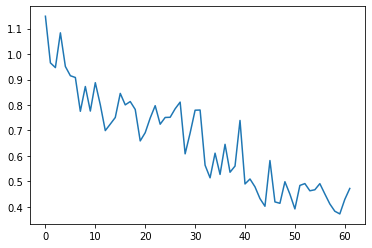

In [15]:
losses = train(train_dataset, val_dataset, model, args)
plt.plot(losses)

## 2.  Mul model with random tensor

In [17]:
model = BertForPronounResolution_Mul.from_pretrained('bert-base-uncased')
model = model.to(device)
torch.cuda.memory_allocated(device)

I1008 21:30:17.400502 140055077836544 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/enlr/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.bf3b9ea126d8c0001ee8a1e8b92229871d06d36d8808208cc2449280da87785c
I1008 21:30:17.401946 140055077836544 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30522
}

I1008 21:30:17.593640 140055077836544 modeli

451988480

step = 15, loss = 1.1237005218863487
step = 31, loss = 0.920777965337038
step = 47, loss = 0.8826075829565525
step = 63, loss = 0.8184746690094471
step = 79, loss = 0.7940855547785759
step = 95, loss = 0.6327568273991346
step = 111, loss = 0.7751007415354252
step = 127, loss = 0.5732534155249596
step = 143, loss = 0.7225133664906025
step = 159, loss = 0.4964753855019808
step = 175, loss = 0.6715438682585955
step = 191, loss = 0.6709572002291679
step = 207, loss = 0.6221309211105108
step = 223, loss = 0.5072571467608213
step = 239, loss = 0.4861067458987236
step = 255, loss = 0.4401726797223091
step = 271, loss = 0.4897484555840492
step = 287, loss = 0.3311552908271551
step = 303, loss = 0.4447301961481571
step = 319, loss = 0.3829392045736313
step = 335, loss = 0.525713250041008
step = 351, loss = 0.6564468964934349
step = 367, loss = 0.38021850772202015
step = 383, loss = 0.4503299258649349
step = 399, loss = 0.33012208715081215
step = 415, loss = 0.42606940120458603
step = 431, loss 

Epoch = 0, Val loss = 0.44244087114930153, val_acc = 0.8392070484581498


step = 15, loss = 0.4028972238302231
step = 31, loss = 0.2863678149878979
step = 47, loss = 0.2936580739915371
step = 63, loss = 0.3006706051528454
step = 79, loss = 0.24156417325139046
step = 95, loss = 0.21456894278526306
step = 111, loss = 0.24160129204392433
step = 127, loss = 0.31364665925502777
step = 143, loss = 0.30859645642340183
step = 159, loss = 0.19833000376820564
step = 175, loss = 0.2422710843384266
step = 191, loss = 0.24770914018154144
step = 207, loss = 0.2825203016400337
step = 223, loss = 0.2604907155036926
step = 239, loss = 0.22405599057674408
step = 255, loss = 0.32405778393149376
step = 271, loss = 0.3167865686118603
step = 287, loss = 0.20104120671749115
step = 303, loss = 0.19454556331038475
step = 319, loss = 0.3186203334480524
step = 335, loss = 0.2658783681690693
step = 351, loss = 0.14997411146759987
step = 367, loss = 0.19376012310385704
step = 383, loss = 0.20909087732434273
step = 399, loss = 0.3035687543451786
step = 415, loss = 0.18859010562300682
ste

Epoch = 1, Val loss = 0.4117751605808735, val_acc = 0.8568281938325991


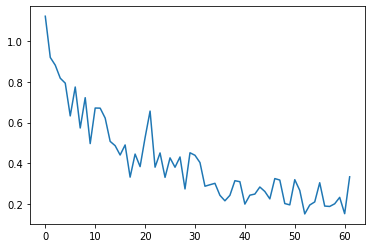

In [18]:
losses = train(train_dataset, val_dataset, model, args)
plt.plot(losses)

## 3.Segment Id model

In [19]:
model = BertForPronounResolution_Segment.from_pretrained('bert-base-uncased')
model.post_init()
model = model.to(device)
torch.cuda.memory_allocated(device)

I1008 21:41:05.119105 140055077836544 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/enlr/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.bf3b9ea126d8c0001ee8a1e8b92229871d06d36d8808208cc2449280da87785c
I1008 21:41:05.120400 140055077836544 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30522
}

I1008 21:41:05.288268 140055077836544 modeli

452001280

step = 15, loss = 1.192443486303091
step = 31, loss = 1.111688058823347
step = 47, loss = 1.1073453016579151
step = 63, loss = 1.1092772148549557
step = 79, loss = 1.043979711830616
step = 95, loss = 1.0459546260535717
step = 111, loss = 0.9978457242250443
step = 127, loss = 1.0003958940505981
step = 143, loss = 0.9567553885281086
step = 159, loss = 0.9407192729413509
step = 175, loss = 0.9791903123259544
step = 191, loss = 0.9368719160556793
step = 207, loss = 0.9314477033913136
step = 223, loss = 0.9579681642353535
step = 239, loss = 0.8496727831661701
step = 255, loss = 1.0228974185883999
step = 271, loss = 1.0319791845977306
step = 287, loss = 0.8281169533729553
step = 303, loss = 0.959046084433794
step = 319, loss = 0.8543483428657055
step = 335, loss = 0.9448858611285686
step = 351, loss = 0.9603137001395226
step = 367, loss = 0.9265043511986732
step = 383, loss = 1.0628062300384045
step = 399, loss = 0.9613110460340977
step = 415, loss = 0.9757391922175884
step = 431, loss = 0.9

Epoch = 0, Val loss = 1.0351071953773499, val_acc = 0.44052863436123346


step = 15, loss = 1.1524520553648472
step = 31, loss = 0.9846697524189949
step = 47, loss = 0.8483834937214851
step = 63, loss = 0.8636492118239403
step = 79, loss = 0.8503886424005032
step = 95, loss = 0.9095340557396412
step = 111, loss = 1.0068155974149704
step = 127, loss = 0.9377408251166344
step = 143, loss = 0.8824710957705975
step = 159, loss = 0.9317584112286568
step = 175, loss = 0.8664837293326855
step = 191, loss = 0.987488329410553
step = 207, loss = 0.8573356866836548
step = 223, loss = 0.882028840482235
step = 239, loss = 1.0146017670631409
step = 255, loss = 0.8734716139733791
step = 271, loss = 0.9413645528256893
step = 287, loss = 0.9465968385338783
step = 303, loss = 0.9594631567597389
step = 319, loss = 0.9494119957089424
step = 335, loss = 0.9081223756074905
step = 351, loss = 0.885796956717968
step = 367, loss = 0.9320777617394924
step = 383, loss = 1.0141573175787926
step = 399, loss = 0.9288853630423546
step = 415, loss = 0.840219970792532
step = 431, loss = 0.8

Epoch = 1, Val loss = 1.0187752544879913, val_acc = 0.5044052863436124


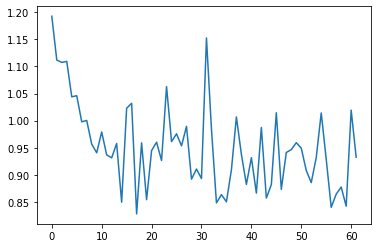

In [20]:
losses = train(train_dataset, val_dataset, model, args)
plt.plot(losses)